# Problem Statement
---
Reddit is a collection of online discussion boards known as "subreddits", which cover a variety of topics. In this project we will be looking into the subreddits, dating_advice and relationship_advice. The choice of these two subreddits is motivated by their text-heavy posts. We will be creating and comparing two models: a logistic regression and a multinomial naive Bayes classifier. Our results may be useful for any reddit user who is unsure which subreddit is the most appropriate to submit his new post, so that he can attract the most comments.

# Data Cleaning and EDA

In [41]:
# import libraries
import pandas as pd, numpy as np
import re
from xml.sax.saxutils import unescape
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [42]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore',category=FutureWarning)

Import the data that was previously collected from our 2 subreddits.

In [43]:
df = pd.read_csv('data/reddit-posts.csv')

Recall that the "scraping" function returned each posts into a dataframe, let us take a look at the size of the data as well as the first 5 observations in the dataframe to get a flavor of the content of the raw data collected.

In [44]:
# look at the shape and the first five rows of the dataset
print(df.shape)
print(df['subreddit'].value_counts())
df.head()

(2502, 4)
dating_advice          1252
relationship_advice    1250
Name: subreddit, dtype: int64


,name,title,text,subreddit
0,t3_co1xjb,FAQ: Where do you meet people?,Hi everyone. In an effort to put together a FA...,dating_advice
1,t3_dkzok7,"Daily Free-for-all Discussion- October 21, 2019",Welcome to /r/dating_advice. Please use this d...,dating_advice
2,t3_dlf3t6,No girl ever seemed interested in me [19M],Almost all my friends have/have had girlfriend...,dating_advice
3,t3_dlon52,It sucks being an introvert in an extrovert’s ...,I’ve had a lot of dates describe me as timid o...,dating_advice
4,t3_dlq2hv,Guys do you like it when a girl asks you out?,Im (f24) I’m thinking of asking out this boy(m...,dating_advice


The dataframe has been split into 4 columns with 2502 posts/observations collected from the selected subreddits, dating_advice and relationship_advice. At first glance, there seems to be a sizable amount of observations collected. However, as this is the raw data we are looking at, let us look at the final dataframe again after data cleaning.

|Column|Data|
|---|---|
|name|ID of the post|
|title|Title of the post|
|text|Content of the post|
|subreddit|Type of subreddits|

Now, let us drop all duplicates that may be collected during the data collection process. Although duplicates often indicate frequency which might affect the score during modeling, this is not the case in this instance as the "name" column contains the unique ID of each post.

In [45]:
# Drop duplicate rows by comparing name ids
df.drop_duplicates(subset='name', inplace=True)

In [46]:
# look at the shape of the data set after dropping duplicates
print(df.shape)
df['subreddit'].value_counts()

(1925, 4)


relationship_advice    975
dating_advice          950
Name: subreddit, dtype: int64

In [47]:
print(950/1925)
print(975/1925)

0.4935064935064935
0.5064935064935064


There are 577 duplicate posts that were dropped. It also shows that there are more posts in the subreddit relationship_advice as compared to dating_advice. With that, we will now explore if there are any null values in the dataset.

In [48]:
# check for null values
df.isnull().sum()

name          0
title         0
text         21
subreddit     0
dtype: int64

In [49]:
# look at the rows with null texts
print(df[df.text.isnull()]['subreddit'].value_counts())
df[df.text.isnull()]

dating_advice          12
relationship_advice     9
Name: subreddit, dtype: int64


,name,title,text,subreddit
46,t3_dlsgkd,Dealing with my Jealousy,NaN,dating_advice
123,t3_dlo5p7,UPDATE ON I SAW A TEXT EXCHANGE BETWEEN BF AND...,NaN,dating_advice
188,t3_dliogq,It has been 4 days since college started and I...,NaN,dating_advice
244,t3_dlewf7,How do I (M20) give this girl (F20) subtle hin...,NaN,dating_advice
352,t3_dl7gzn,Friendship,NaN,dating_advice
353,t3_dl7gq9,I recently read a research article which state...,NaN,dating_advice
410,t3_dl7ppn,I lie,NaN,dating_advice
446,t3_dl1fkz,Kevin McCoy,NaN,dating_advice
751,t3_dkheda,Waiting for a text,NaN,dating_advice
857,t3_dkcdem,Please help,NaN,dating_advice


There are 21 posts with no text. Of these 21 posts, there are 12 and 9 posts from subreddit category, dating_advice and relationship_advice respectively. Due to limited context from just the title alone, i will choose to drop these columns to avoid training the model which might not be beneficial in predicting the subreddit of a new post. 

In [50]:
df.dropna(axis=0,inplace=True)

relationship_advice    966
dating_advice          938
Name: subreddit, dtype: int64


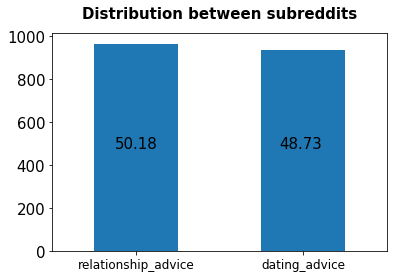

In [51]:
# find number of posts from each subreddit
print(df['subreddit'].value_counts())
df['subreddit'].value_counts().plot(kind='bar');
# plot the graph to show the number of posts from each subreddit
plt.xticks(fontsize=12,rotation=0);
plt.title('Distribution between subreddits',fontsize=15,pad=15,fontweight='bold');
plt.figtext(0.27,0.48,round((966/1925*100),2),fontsize=15);
plt.figtext(0.65,0.48,round((938/1925*100),2),fontsize=15);

There is an uneven distribution number of posts between the relationship_advice and dating_advice. However, since the difference is minor, it should not have a significant impact in the model that we will be training. Next, we will be combining the title and text together and apply a series of data cleaning techniques on this newly combined column.

In [52]:
# Put titles and texts into a single column.
df['full_text'] = df['title'] + ' ' + df['text']

In [53]:
# Convert &amp;, &gt; and &lt; XML character entity references back to &, > and <
df['full_text'] = df['full_text'].apply(unescape)

In [54]:
# remove all newline ("\n") from text
df['full_text'] = [re.sub("\n"," ",i) for i in df['full_text']]

In [55]:
# remove punctuation
df['full_text'] = [re.sub("[^A-z]"," ",i) for i in df['full_text']]

In [56]:
# remove words with 2 or fewer letters
df['full_text'] = [re.sub("\b\w{1,2}\b"," ",i) for i in df['full_text']]

Notice that we did not remove stop words while cleaning the data as it can be applied as a parameter when applying vectorizer on the data.

In [57]:
# import CountVectorizer and TfidfVectorizer form sklearn library
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# instantiate CountVectorizer and TfidfVectorizer with stopwords
cvec = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')

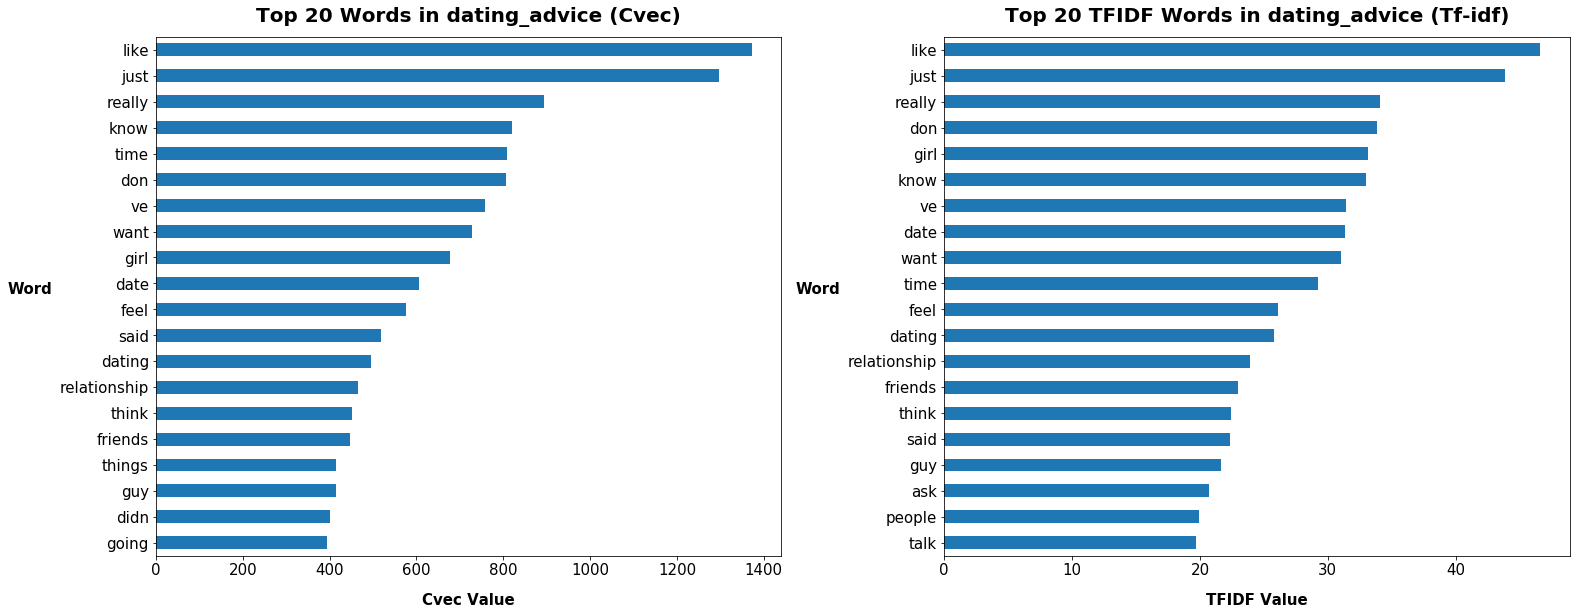

In [58]:
# explore CountVectorizer token counts in dating_advice
cvec_da = pd.DataFrame(cvec.fit_transform(df[df['subreddit']=='dating_advice']['full_text']).todense(),
                       columns=cvec.get_feature_names())
cvec_count_da = cvec_da.sum(axis=0)

# explore TfidfVectorizer token counts in dating_advice
tfidf_da = pd.DataFrame(tfidf.fit_transform(df[df['subreddit']=='dating_advice']['full_text']).todense(),
                       columns=tfidf.get_feature_names())
tfidf_count_da = tfidf_da.sum(axis=0)

# plot top 20 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
cvec_count_da.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in dating_advice (Cvec)',fontsize=20,pad=15,fontweight='bold')
plt.xlabel('Cvec Value',fontsize=15,labelpad =15,fontweight='bold')
plt.ylabel('Word',fontsize=15,rotation=0,labelpad=30,fontweight='bold')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

plt.subplot(2,2,2)
tfidf_count_da.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in dating_advice (Tf-idf)',fontsize=20,pad=15,fontweight='bold')
plt.xlabel('TFIDF Value',fontsize=15,labelpad =15,fontweight='bold')
plt.ylabel('Word',fontsize=15,rotation=0,labelpad=30,fontweight='bold')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

plt.tight_layout()

The most common words in dating_advice after vectorizing with stop words are "like", "just" and "really". 

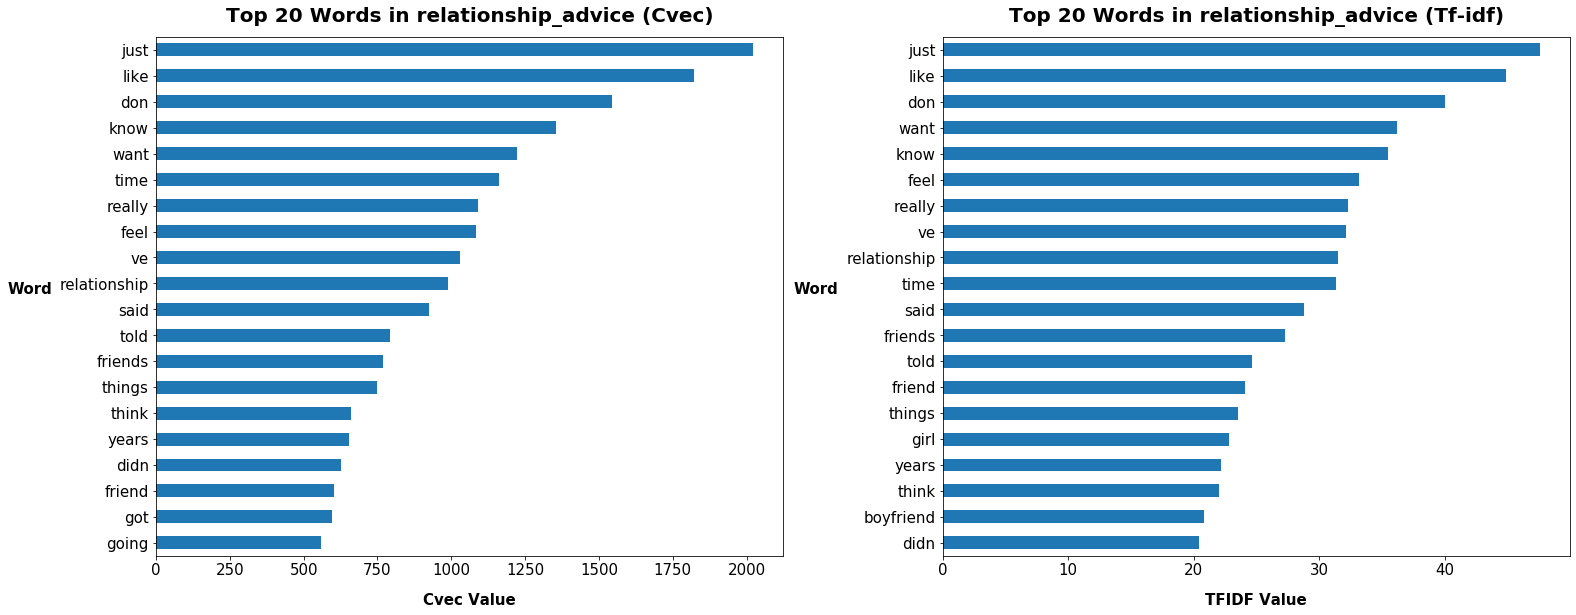

In [59]:
# explore CountVectorizer token counts in relationship_advice
cvec_ra = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='relationship_advice']['full_text']).todense(),
                       columns=cvec.get_feature_names())
cvec_counts_ra = cvec_ra.sum(axis=0)

# explore TfidfVectorizer token counts in relationship_advice
tfidf_ra = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='relationship_advice']['full_text']).todense(),
                       columns=tfidf.get_feature_names())
tfidf_counts_ra = tfidf_ra.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
cvec_counts_ra.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in relationship_advice (Cvec)',fontsize=20,pad=15,fontweight='bold')
plt.xlabel('Cvec Value',fontsize=15,labelpad =15,fontweight='bold')
plt.ylabel('Word',fontsize=15,rotation=0,labelpad=30,fontweight='bold')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

plt.subplot(2,2,2)
tfidf_counts_ra.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in relationship_advice (Tf-idf)',fontsize=20,pad=15,fontweight='bold')
plt.xlabel('TFIDF Value',fontsize=15,labelpad =15,fontweight='bold')
plt.ylabel('Word',fontsize=15,rotation=0,labelpad=30,fontweight='bold')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

plt.tight_layout()

The most common words in relationship_advice after vectorizing with stop words are "just", "like" and "don".

There are many common words used interchangeably in both dating_advice and relationship_advice. Hence, there is a higher chance that our model will perform better when we apply Tf-idfVectorizer, which gives a high weight to any term that appears often in a particular document, but not in many documents in the corpus.

# Preprocessing and Modeling

Before we begin with our modeling, we will be creating a new column to map dating_advice and relationship_advice into a 0 and 1 category where 0 is relationship_advice while 1 is dating_advice before getting our baseline accuracy score.

In [60]:
# create target variable, y which maps subreddit into a 1/0 column, where 1 indicates dating_advice
df['y'] = [1 if i == 'dating_advice' else 0 for i in df['subreddit']]

## Baseline

In [61]:
df['y'].value_counts(normalize=True)

0    0.507353
1    0.492647
Name: y, dtype: float64

The baseline accuracy for relationship_advice is 0.507353 and 0.492647 for dating_advice. With that, we will create our X and y variables with X being the column which we combined the title and text together and y being the numeric subreddit category which was just created. Thereafter, we will do a train test split on the X and y variables and begin training our model.

In [62]:
# creating our X and y features
X = df['full_text']
y = df['y']

In [63]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## CountVectorizer and LogisticRegression

In [64]:
# Fit and predict a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

logr_model_cvec = make_pipeline(
    cvec,
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42)
)
cv_scores = cross_val_score(logr_model_cvec, X_train, y_train, cv=5, scoring='roc_auc')
logr_model_cvec.fit(X_train, y_train)
y_pred = logr_model_cvec.predict(X_test)
print('Logistic regression model')
print(f'Train score: {round(cv_scores.mean(), 4)}')
print(f'Test score: {round(roc_auc_score(y_test, y_pred), 4)}')
print(f'Number of features: {len(logr_model_cvec.named_steps.countvectorizer.get_feature_names())}')

Logistic regression model
Train score: 0.8197
Test score: 0.7119
Number of features: 9908


/Users/kenricklow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Our first model using CountVectorizer and LogisticRegression has a train score of 0.8197 and test score of 0.7119. The model is also overfitted. Now, keeping LogisticRegression constant, let us see if we can reduce overfitting in the model while improving the train and test score if we use TfidfVectorizer instead.

## TfidfVectorizer and LogisticRegression

In [65]:
logr_model_tfidf = make_pipeline(
    tfidf,
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42)
)
cv_scores = cross_val_score(logr_model_tfidf, X_train, y_train, cv=5, scoring='roc_auc')
logr_model_tfidf.fit(X_train, y_train)
y_pred = logr_model_tfidf.predict(X_test)
print('Logistic regression model')
print(f'Train score: {round(cv_scores.mean(), 4)}')
print(f'Test score: {round(roc_auc_score(y_test, y_pred), 4)}')
print(f'Number of features: {len(logr_model_tfidf.named_steps.tfidfvectorizer.get_feature_names())}')

Logistic regression model
Train score: 0.8562
Test score: 0.7748
Number of features: 9908


Indeed, the model fitted using TfidfVectorizer together with LogisticRegression has a better train and test score. Overfitting was also reduced slightly. It seems that TfidfVectorizer performs better than countvectorizer. For the next 2 models, we will use a multinomial Naive Bayers classifier together with CountVectorizer and TfidfVectorizer to look at the performance between the different linear model.

## CountVectorizer and MultinomialNB

In [66]:
# Fit and predict a multinomial naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

mnb_model_cvec = make_pipeline(
    cvec,
    MultinomialNB()
)
cv_scores = cross_val_score(mnb_model_cvec, X_train, y_train, cv=5, scoring='roc_auc')
mnb_model_cvec.fit(X_train, y_train)
y_pred = mnb_model_cvec.predict(X_test)
print('Multinomial naive Bayes classifier')
print(f'Train score: {round(cv_scores.mean(), 4)}')
print(f'Test score: {round(roc_auc_score(y_test, y_pred), 4)}')
print(f'Number of features: {len(mnb_model_cvec.named_steps.countvectorizer.get_feature_names())}')

Multinomial naive Bayes classifier
Train score: 0.8512
Test score: 0.7708
Number of features: 9908


## TfidfVectorizer and MultinomialNB

In [67]:
mnb_model_tfidf = make_pipeline(
    tfidf,
    MultinomialNB()
)
cv_scores = cross_val_score(mnb_model_tfidf, X_train, y_train, cv=5, scoring='roc_auc')
mnb_model_tfidf.fit(X_train, y_train)
y_pred = mnb_model_tfidf.predict(X_test)
print('Multinomial naive Bayes classifier')
print(f'Train score: {round(cv_scores.mean(), 4)}')
print(f'Test score: {round(roc_auc_score(y_test, y_pred), 4)}')
print(f'Number of features: {len(mnb_model_tfidf.named_steps.tfidfvectorizer.get_feature_names())}')

Multinomial naive Bayes classifier
Train score: 0.8552
Test score: 0.7582
Number of features: 9908


The model with the best performance is surprisingly the model fitted with TfidfVectorizer and LogisticRegression while the model fitted with CountVectorizer and Multinomial Naive Bayes in a close second even though all the models are still overfitted. With that, the next step is to explore if applying lemmatization will further improve our model.

|Specifications|Stem|Train Score|Test Score|
|---|---|---|---|
|CountVectorizer & LogisticRegression|NA|0.8197|0.7119|
|TfidfVectorizer & LogisticRegression|NA|0.8562|0.7748|
|CountVectorizer & MultinomialNB|NA|0.8512|0.7708|
|TfidfVectorizer & MultinomialNB|NA|0.8552|0.7582|

## Lemmatization

In [68]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [69]:
def lemmatize_words(text):
    words = text.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words

In [70]:
df['full_text_lemma'] = df['full_text'].apply(lemmatize_words)

In [71]:
X_lemma = df['full_text_lemma']

In [72]:
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma, y, random_state=42, stratify=y)

## CountVectorizer(Lemmatizer) and LogisticRegression

In [73]:
# Fit and predict a logistic regression model
logr_cvec_lemma = make_pipeline(
    cvec,
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42, max_iter=1000)
)
cv_scores = cross_val_score(logr_cvec_lemma, X_train_lemma, y_train_lemma, cv=5, scoring='roc_auc')
logr_cvec_lemma.fit(X_train_lemma, y_train_lemma)
y_pred = logr_cvec_lemma.predict(X_test_lemma)
print('Logistic regression model')
print(f'Train score: {round(cv_scores.mean(), 4)}')
print(f'Test score: {round(roc_auc_score(y_test_lemma, y_pred), 4)}')
print(f'Number of features: {len(logr_cvec_lemma.named_steps.countvectorizer.get_feature_names())}')

Logistic regression model
Train score: 0.8188
Test score: 0.7203
Number of features: 8958


## TfidfVectorizer(Lemmatizer) and LogisticRegression

In [74]:
logr_tfidf_lemma = make_pipeline(
    tfidf,
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42)
)
cv_scores = cross_val_score(logr_tfidf_lemma, X_train_lemma, y_train_lemma, cv=5, scoring='roc_auc')
logr_tfidf_lemma.fit(X_train_lemma, y_train_lemma)
y_pred = logr_tfidf_lemma.predict(X_test_lemma)
print('Logistic regression model')
print(f'Train score: {round(cv_scores.mean(), 4)}')
print(f'Test score: {round(roc_auc_score(y_test_lemma, y_pred), 4)}')
print(f'Number of features: {len(logr_tfidf_lemma.named_steps.tfidfvectorizer.get_feature_names())}')

Logistic regression model
Train score: 0.8568
Test score: 0.779
Number of features: 8958


## CountVectorizer(Lemmatizer) and MultinomialNB

In [75]:
# Fit and predict a multinomial naive Bayes classifier (suits with discrete features)
mnb_cvec_lemma = make_pipeline(
    cvec,
    MultinomialNB()
)
cv_scores = cross_val_score(mnb_cvec_lemma, X_train_lemma, y_train_lemma, cv=5, scoring='roc_auc')
mnb_cvec_lemma.fit(X_train_lemma, y_train_lemma)
y_pred = mnb_cvec_lemma.predict(X_test_lemma)
print('Multinomial naive Bayes classifier')
print(f'Train score: {round(cv_scores.mean(), 4)}')
print(f'Test score: {round(roc_auc_score(y_test_lemma, y_pred), 4)}')
print(f'Number of features: {len(mnb_cvec_lemma.named_steps.countvectorizer.get_feature_names())}')

Multinomial naive Bayes classifier
Train score: 0.8533
Test score: 0.7688
Number of features: 8958


## TfidfVectorizer(Lemmatizer) and MultinomialNB

In [76]:
mnb_tfidf_lemma = make_pipeline(
    tfidf,
    MultinomialNB()
)
cv_scores = cross_val_score(mnb_cvec_lemma, X_train_lemma, y_train_lemma, cv=5, scoring='roc_auc')
mnb_tfidf_lemma.fit(X_train_lemma, y_train_lemma)
y_pred = mnb_tfidf_lemma.predict(X_test_lemma)
print('Multinomial naive Bayes classifier')
print(f'Train score: {round(cv_scores.mean(), 4)}')
print(f'Test score: {round(roc_auc_score(y_test_lemma, y_pred), 4)}')
print(f'Number of features: {len(mnb_cvec_lemma.named_steps.countvectorizer.get_feature_names())}')

Multinomial naive Bayes classifier
Train score: 0.8533
Test score: 0.7562
Number of features: 8958


After lemmatization, 4 models of the same type was fitted and scored with the results as below. The overall best performing model is the model fitted with TfidfVectorizer, lemmatization applied and LogisticRegression. However, it is only slightly better than the model fitted with TfidfVectorizer without lemmatization and LogisticRegression. With that, we will perform GridSearchCV on our model fitted with TfidfVectorizer with lemmatization applied and LogisticRegression to find out what are the best parameters to fit together with the model.

|Specifications|Stem|Train Score|Test Score|
|---|---|---|---|
|CountVectorizer & LogisticRegression|NA|0.8197|0.7119|
|TfidfVectorizer & LogisticRegression|NA|0.8562|0.7748|
|CountVectorizer & MultinomialNB|NA|0.8512|0.7708|
|TfidfVectorizer & MultinomialNB|NA|0.8552|0.7582|
|CountVectorizer & LogisticRegression|Lemma|0.8188|0.7203|
|TfidfVectorizer & LogisticRegression|Lemma|0.8568|0.779|
|CountVectorizer & MultinomialNB|Lemma|0.8533|0.7688|
|TfidfVectorizer & MultinomialNB|Lemma|0.8533|0.7562|

## GridSearch

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [78]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('log_reg', LogisticRegression())
])

parameters = {
    'tfidf__stop_words': ['english'],
    'tfidf__max_df': [0.25, 0.5, 0.75],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [2000,3000,4000,5000,6000,7000,8000,9000,10000],
    'log_reg__solver': ['lbfgs'],
    'log_reg__multi_class': ['auto'],
    'log_reg__random_state': [42]
}

gs = GridSearchCV(pipe, parameters, cv=5, scoring='roc_auc', iid=False, n_jobs=-1, verbose=1)
gs.fit(X_train_lemma, y_train_lemma)
print(f"Best params: {gs.best_params_}")
print(f'Train score: {round(gs.best_score_, 4)}')
print(f'Test score: {round(gs.best_estimator_.score(X_test_lemma, y_test_lemma), 4)}')
print(f'Number of features: {len(gs.best_estimator_.named_steps.tfidf.get_feature_names())}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  3.3min finished


Best params: {'log_reg__multi_class': 'auto', 'log_reg__random_state': 42, 'log_reg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}
Train score: 0.8627
Test score: 0.7878
Number of features: 10000


Since we kept the parameters for LogisticRegression constant, GridSearchCV chose the best parameters for TfidfVectorizer and return the model with the best score thus far. The best parameters for TfidfVectorizer are as follows:

- max_df: 0.5
- max_features: 10000
- ngram_range: (1, 3)
- stop_words: english

|Specifications|Stem|Train Score|Test Score|
|---|---|---|---|
|CountVectorizer & LogisticRegression|NA|0.8197|0.7119|
|TfidfVectorizer & LogisticRegression|NA|0.8562|0.7748|
|CountVectorizer & MultinomialNB|NA|0.8512|0.7708|
|TfidfVectorizer & MultinomialNB|NA|0.8552|0.7582|
|CountVectorizer & LogisticRegression|Lemma|0.8188|0.7203|
|TfidfVectorizer & LogisticRegression|Lemma|0.8568|0.779|
|CountVectorizer & MultinomialNB|Lemma|0.8533|0.7688|
|TfidfVectorizer & MultinomialNB|Lemma|0.8533|0.7562|
|GridSearch(TfidfVectorizer & MultinomialNB)|Lemma|0.8627|0.7878|

As such, we will be using the model with TfidfVectorizer together with the parameters selected for TdidfVectorizer and LogisticRegression.

# Evaluation and Conceptual Understanding

In [79]:
logr_tfidf_lemma = make_pipeline(
    TfidfVectorizer(max_df=0.5,max_features=10000,ngram_range=(1, 3),stop_words='english'),
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42)
)
logr_tfidf_lemma.fit(X_train_lemma, y_train_lemma)
y_pred = logr_tfidf_lemma.predict(X_test_lemma)

In [80]:
# Generate a confusion matrix
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_test_lemma, y_pred),
            columns=['predict dating_advice', 'predict relationship_advice'],
            index=['actual dating_advice', 'actual relationship_advice'])

,predict dating_advice,predict relationship_advice
actual dating_advice,196,46
actual relationship_advice,55,179


In [81]:
# Examine some classification metrics 
tn, fp, fn, tp = confusion_matrix(y_test_lemma, y_pred).ravel()
print(f'Accuracy: {round((tp+tn)/(tp+fp+tn+fn),4)}')
print(f'Misclassification rate: {round((fp+fn)/(tp+fp+tn+fn),4)}')
print(f'Precision: {round(tp/(tp+fp),4)}')
print(f'Recall: {round(tp/(tp+fn),4)}')
print(f'Specificity: {round(tn/(tn+fp),4)}')

Accuracy: 0.7878
Misclassification rate: 0.2122
Precision: 0.7956
Recall: 0.765
Specificity: 0.8099


- Our model correctly predicts 78.78% of observations.
- Among posts that our model predicted to be in relationship_advice, we have 79.56% of them correctly classified.
- Among posts that are in relationship_advice, our model has 76.50% of them correctly classified.
- Among posts that are in dating_advice, our model has 80.99% of them correctly classified.

In [86]:
# Examine incorrectly classified posts
df_pred = pd.DataFrame({
    'X_test': X_test_lemma,
    'y_test': y_test_lemma,
    'y_pred': y_pred
})

# Posts incorrectly predicted to be in dating_advice
for i in df_pred[(df_pred['y_test'] - df_pred['y_pred']) > 0]['X_test']:
    print(i)
    print('-'*20)

Am I wrong for feeling upset Everyone is y o So long story short I have feeling for my best friend I ll cal him J and I have reason to believe that at one point he did too but cut thing off because he doesn t like feeling make him feel out of control Now I have a friend female that I invited over once a couple of month ago because she wa going through some problem and my group of friend are fun people and I wanted to make her feel better I told her my situation with J and explained that it would upset me if they ever got involved She assured me nothing would ever happen because she care about me Fast forward a couple week and she end up sleeping in his bed with him They weren t physical but the situation made me uncomfortable and I expressed this to her She explained it wa an accident Fast forward like a month to Saturday night We were all drinking She go upstairs to fall asleep on the couch I went up there to talk to her about another unrelated situation and J wa there sleeping on the

In [87]:
# Posts incorrectly predicted to be in relationship_advice
for i in df_pred[(df_pred['y_test'] - df_pred['y_pred']) < 0]['X_test']:
    print(i)
    print('-'*20)

When are people called bf and gf and not just dating Just wondering if you guy think that you have to be asked or ask somebody to be their bf gf or if just after a while you guy start to call it that Thoughts 
--------------------
Break up M F the girl ive been seeing for about month just texted me she s ending thing with me cause she thought i wa which it showed on my dating app but she think i lied to her but i tried explaining that i completely forgot that wa the age there but she say it over what do i do am really anxious cause we connected so well 
--------------------
How do I ask her if the upcomming hang ouf still a thing is I had the gut to ask her to hang out the second time since she ditched the first time wanred to watch Joker with her but she didn t wanna watch the movie So we planned to meet up on comming sunday but today I heard her talking to friend and planning on going to something like a shopping center on sunday What is a good question to ask if the thing on sunday 

# Conclusion and Recommendations

- Our logistic regression did not perform too well with a test accuracy score of 78.78%. This is within expectations because the topics of our two chosen subreddits does not differ significantly.
- Scope for future improvements:
    - Optimize stop words and explore strategies for stemming
    - Try ensemble models, such as random forest classifier
    - Colleect more data that are posted accurately in their respective subreddits